In [1]:
import becquerel as bq
from becquerel import Spectrum
from becquerel.tools.isotope import Isotope
from becquerel.tools.isotope_qty import IsotopeQuantity, NeutronIrradiation
import datetime
import numpy as np
import scipy.integrate as integrate
import math as m
import importlib
import pandas as pd
import sys
import os
import csv
import matplotlib.pyplot as plt
import re
sys.path.insert(0,r"C:\Users\Daniel\Desktop\Radwatch\radwatch-analysis")

In [2]:
import PF
import naa_isotope_analyzer as naa
import analysis_methods as am
import ROI
importlib.reload(PF)
importlib.reload(naa)
importlib.reload(am)
importlib.reload(ROI)

C:\Users\Daniel\Anaconda3\lib\site-packages\html5lib\_trie\_base.py:3: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping


<module 'ROI' from 'C:\\Users\\Daniel\\Desktop\\Radwatch\\radwatch-analysis\\ROI.py'>

In [3]:
def get_isotopes(energies):
    hl_cut = 600 #in becq.fetch decay radiation
    br_cut =4.0
    df = naa.naa_isotope_analyzer(energies,hl_cut,br_cut,5.0,.4)
    
    return df

In [4]:
sample_masses = [1.0,1.1,1.0,1.1,1.0,1.0,1.1,1.0,0.9,1.0]
sample_fish = ["Petrale Sole 1","Halibut","Tilapia","Rockfish","Rock Cod","Catfish","Petrale Sole 2",
               "Wild King Salmon","Swordfish","Oysters"]
sample_mass_unc = 0.1

In [5]:
sample_index = 8

In [6]:
#use the ecal and bgspec from google drive
#implement choosing between relevant ecal and bg for diff sample groups
path = r"C:\Users\Daniel\Desktop\Radwatch\FishSamples2019"
e_cal = np.loadtxt(path + r"\11-19-2019-Calibration.Ent")
bgspec =  Spectrum.from_file(path + r"\Background_Spectrum_12_20_19.Spe")

SpeFile: Reading file C:\Users\Daniel\Desktop\Radwatch\FishSamples2019\Background_Spectrum_12_20_19.Spe


In [7]:
#specs for testing
sample_name = r"\ucb19"
if sample_index < 9:
    sample_name = sample_name + "0"
sample_name = sample_name + str(sample_index+1)
print(sample_name)
spec_30 = Spectrum.from_file(path+sample_name + "-30min.Spe")
spec_03 = Spectrum.from_file(path+sample_name + "-3hr.Spe")
spec_24 = Spectrum.from_file(path+sample_name+"-24hr.Spe")

\ucb1909
SpeFile: Reading file C:\Users\Daniel\Desktop\Radwatch\FishSamples2019\ucb1909-30min.Spe
SpeFile: Reading file C:\Users\Daniel\Desktop\Radwatch\FishSamples2019\ucb1909-3hr.Spe
SpeFile: Reading file C:\Users\Daniel\Desktop\Radwatch\FishSamples2019\ucb1909-24hr.Spe


In [8]:
specs= [spec_30,spec_03,spec_24]
cal_specs = []
for i in range(len(specs)):
    specs[i].calibrate_like(bgspec)
    cal_specs.append(specs[i])

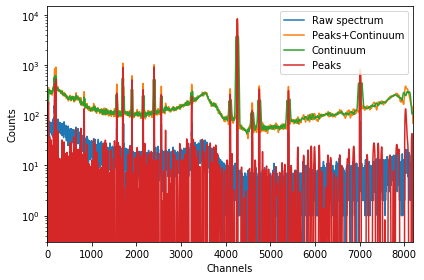

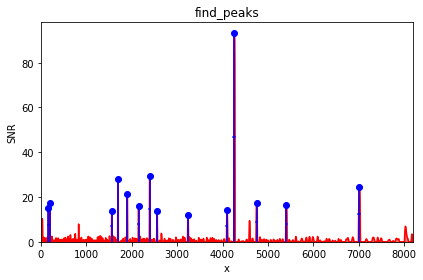

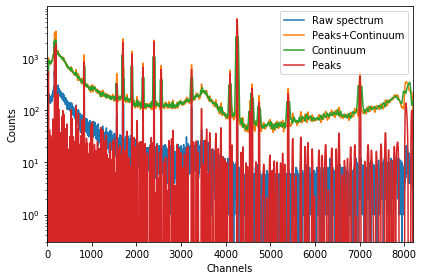

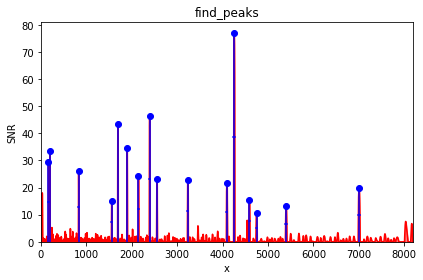

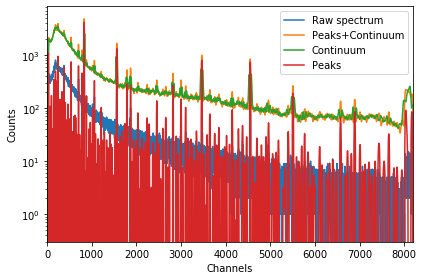

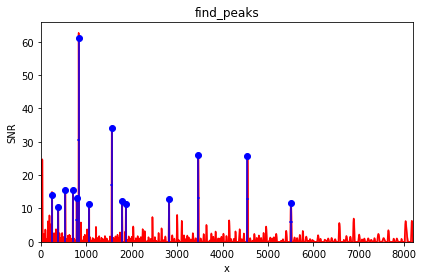

In [9]:
energies = []
for i in range(len(cal_specs)):
    energies.append(am.get_energies(cal_specs[i])) #peak finding method, bq.peakfinder


In [10]:
print(energies)

[array([  67,   76,  509,  552,  617,  696,  774,  826, 1042, 1315, 1366,
       1522]), array([  67,   76,  278,  509,  552,  617,  696,  774,  825, 1041, 1314,
       1365, 1471, 1521]), array([  91,  135,  184,  237,  263,  278,  350,  509,  581,  607,  909,
       1114])]


In [11]:
energy_shift = 3

In [12]:
iso_dfs =[]
#isotope analyzer improvement
for e in energies:
    e = e + energy_shift
    iso_dfs.append(get_isotopes(e))

Backround isotopes [[], [], [], [], [], [], ['PB211'], [], [], [], []]
Possible isotopes [['PD111', 'ND149', 'SM153', 'GD153', 'TA182', 'W187', 'W187', 'W187', 'RE188', 'RE188', 'OS185', 'OS185', 'OS191', 'OS191', 'OS191', 'OS193', 'OS193', 'IR192', 'PT193', 'PT195', 'PT195', 'PT197', 'PT197', 'AU198', 'HG197', 'HG199', 'HG203', 'HG203', 'BI210', 'BI210', 'U239'], ['MO101', 'AG108', 'TE131', 'XE133', 'BA131', 'BA133', 'BA133', 'ND151', 'HO166', 'HO166', 'TM170', 'TA182', 'AU198', 'HG197', 'HG197', 'HG197', 'HG199', 'HG199', 'HG199', 'HG203', 'BI210'], ['GE77', 'AS76', 'BR82', 'IN114', 'OS193'], ['ZN71', 'ZN71', 'BR82', 'AG110', 'BA131', 'W187'], ['BR82', 'ZR97', 'NB94'], ['GE77', 'BR82', 'MO99', 'TE131', 'EU152', 'HO166'], ['GA72', 'KR79', 'HO166'], ['GA72', 'BR82', 'SB124', 'BA131'], ['BR82'], ['NA24', 'GE77', 'SB124'], ['K42']]
Possible isotope br [[90.4+/-2.3, 1.11+/-0.24, 4.73+/-0.05, 2.42+/-0.07, 1.31+/-0.03, 3.17+/-0.09, 1.11+/-0.03, 13.55+/-0.21, 6.3+/-0.6, 2.21+/-0.2, 7.6+/-0.3

In [13]:
eff_func = am.Efficiency()
eff_func.set_parameters()

Loaded fit parameters 0-4: [-0.00530667  0.04316717 -0.01324963 -0.95566839 -4.73673214]
Loaded input energies: []
Loaded energy uncertainties: [0.03200221 0.03639874 0.03102208 0.00876822]


In [14]:
counts = []

uncertainties =[]

icounts = []
iuncertainties = []
#uses PF.PF 
for i in range(len(cal_specs)):
    icounts, iuncertainties = am.get_counts(cal_specs[i],bgspec,energies[i])
    counts.append(icounts)
    uncertainties.append(np.sqrt(icounts))

c:\users\daniel\desktop\radwatch\becquerel\becquerel\core\spectrum.py:726: SpectrumWarning: Subtraction of counts-based specta, spectra have been converted to CPS
  'have been converted to CPS', SpectrumWarning)


In [15]:
print(energies[0])
print(counts[0])
print(uncertainties[0])# the uncertainties are all over the place or equal to the real value
print(energies[1])
print(counts[1])
print(uncertainties[1])# the uncertainties are all over the place or equal to the real value


[  67   76  509  552  617  696  774  826 1042 1315 1366 1522]
[1005.03474646  813.19359535  465.83109509 1147.44773468  598.45826522
  372.45963926 1010.27188274  300.17477315  234.21043371  285.58979198
 8864.84942193  340.39979785]
[31.70228299 28.5165495  21.58312061 33.87399791 24.46340666 19.29921344
 31.78477439 17.32555261 15.30393524 16.89940212 94.15332932 18.44992677]
[  67   76  278  509  552  617  696  774  825 1041 1314 1365 1471 1521]
[3355.60821693 7876.85751737 1029.02504633  336.3984326  2562.92974027
 1441.1831213   786.75802235 2355.48085426  674.58483062  670.72217794
  569.49022229 6105.67000907  291.19461193  148.25245778]
[57.92761187 88.75166205 32.07842026 18.3411677  50.62538632 37.96291771
 28.04920716 48.53329635 25.97277095 25.89830454 23.86399427 78.13878684
 17.06442533 12.17589659]


In [16]:
ec = np.array([[ene, counts[i]/eff_func.get_eff(ene),uncertainties[i]/eff_func.get_eff(ene)] for (i, ene) in enumerate(energies)])

In [17]:
print("These are for spectrum 1")
print("the energies are",ec[0,0])
print("the true counts are",ec[0,1])
print("the unc on the true counts are",ec[0,2])

These are for spectrum 1
the energies are [  67   76  509  552  617  696  774  826 1042 1315 1366 1522]
the true counts are [ 39053.74878646  28248.25092797  20842.90121242  54664.39692332
  31185.8702797   21476.1425001   63885.48070275  20110.01736654
  19403.43585605  29462.38061494 948275.86538407  40374.87471421]
the unc on the true counts are [ 1231.89073812   990.59147842   965.70378274  1613.75687222
  1274.79670833  1112.79884908  2009.93972548  1160.71434039
  1267.87231889  1743.39780824 10071.61267943  2188.3487786 ]


In [18]:
print(ec[1][0])
print(iso_dfs[1].energies[0])

[  67   76  278  509  552  617  696  774  825 1041 1314 1365 1471 1521]
[555, 620, 699, 777, 828, 1044, 1317, 1474]


In [19]:
spectra = 0
for s in range(3):
    iso_dfs[s]['counts'] = "0"
    iso_dfs[s]['count_unc'] = "0"

    for j, e in enumerate(iso_dfs[s]['energies']):
        iso_dfs[s]['counts'][j] = np.zeros(len(e))
        iso_dfs[s]['count_unc'][j] = np.zeros(len(e))

    for i, det_ene in enumerate(ec[s][0]):
        for j, em_enes in enumerate(iso_dfs[s]['energies']):
            for k, in_ene in enumerate(em_enes):
                if (det_ene+energy_shift) == in_ene:
                    iso_dfs[s]['counts'][j][k] = round(ec[s][1][i])
                    iso_dfs[s]['count_unc'][j][k] = round(ec[s][2][i])

In [20]:
for i,df in enumerate(iso_dfs):
    df['cps'] = df['counts']/cal_specs[i].livetime
    df['cps_unc'] = df['count_unc']/cal_specs[i].livetime
    df = df.drop('counts',1)
    iso_dfs[i] = df.drop('count_unc',1)

In [21]:
iso_dfs[0]

,isotopes,energies,branching_ratios,cps,cps_unc
0,BR82,"[555, 620, 699, 777, 1045, 1318]","[71.7, 43.7, 28.4, 83.6, 27.6, 26.9]","[30.36888888888889, 17.325555555555557, 11.931...","[0.8966666666666666, 0.7083333333333334, 0.618..."
1,NA24,[1369],[99.9936],[526.82],[5.595555555555555]
2,AS76,[555],[45.0],[30.36888888888889],[0.8966666666666666]
3,K42,[1525],[18.08],[22.430555555555557],[1.2155555555555555]
4,NB94,[699],[99.814],[11.931111111111111],[0.6183333333333333]


In [35]:
iso_dfs[0] = iso_dfs[0].drop([4])
iso_dfs[0]

,isotopes,energies,branching_ratios,cps,cps_unc,Activity,Act_unc,mass(g),mass(g)-unc,ppm,ppm-unc
0,BR82,"[555, 620, 699, 777, 1045, 1318]","[71.7, 43.7, 28.4, 83.6, 27.6, 26.9]","[30.36888888888889, 17.325555555555557, 11.931...","[0.8966666666666666, 0.7083333333333334, 0.618...",0.433716,0.007415,8.398520e-08,1.435789e-09,0.000933,0.000016
1,NA24,[1369],[99.9936],[526.82],[5.595555555555555],5.268537,0.055959,1.813186e-08,1.925854e-10,0.000201,0.000002
3,K42,[1525],[18.08],[22.430555555555557],[1.2155555555555555],1.240628,0.067232,8.403824e-06,4.554196e-07,0.093376,0.005060


In [23]:
iso_dfs[1]

,isotopes,energies,branching_ratios,cps,cps_unc
0,BR82,"[555, 620, 699, 777, 828, 1044, 1317, 1474]","[71.7, 43.7, 28.4, 83.6, 24.2, 27.6, 26.9, 16.39]","[11.30537037037037, 6.9537962962962965, 4.2004...","[0.22333333333333333, 0.18314814814814814, 0.1..."
1,NA24,[1368],[99.9936],[60.43240740740741],[0.773425925925926]
2,AS76,[555],[45.0],[11.30537037037037],[0.22333333333333333]
3,YB175,[281],[6.13],[2.927037037037037],[0.0912037037037037]
4,K42,[1524],[18.08],[1.6271296296296296],[0.13361111111111112]
5,NB94,[699],[99.814],[4.200462962962963],[0.14972222222222223]


In [24]:
iso_dfs[1] = iso_dfs[1].drop([3,5])
iso_dfs[1]

,isotopes,energies,branching_ratios,cps,cps_unc
0,BR82,"[555, 620, 699, 777, 828, 1044, 1317, 1474]","[71.7, 43.7, 28.4, 83.6, 24.2, 27.6, 26.9, 16.39]","[11.30537037037037, 6.9537962962962965, 4.2004...","[0.22333333333333333, 0.18314814814814814, 0.1..."
1,NA24,[1368],[99.9936],[60.43240740740741],[0.773425925925926]
2,AS76,[555],[45.0],[11.30537037037037],[0.22333333333333333]
4,K42,[1524],[18.08],[1.6271296296296296],[0.13361111111111112]


In [37]:
iso_dfs[2]

,isotopes,energies,branching_ratios,cps,cps_unc,Activity,Act_unc,mass(g),mass(g)-unc,ppm,ppm-unc
8,SC46,[1117],[99.987],[0.9268287037037037],[0.030752314814814816],0.009269,0.000308,4.680819e-10,1.553103e-11,0.000005,1.725670e-07


In [26]:
iso_dfs[2] = iso_dfs[2].drop([0,1,2,3,4,5,6,7,9,10])
iso_dfs[2]

,isotopes,energies,branching_ratios,cps,cps_unc
8,SC46,[1117],[99.987],[0.9268287037037037],[0.030752314814814816]


In [27]:
for df in iso_dfs:
    Activities = []
    act_unc = []
    for i in range(len(df['cps'])):
        Activities.append(np.sum(df['cps'].iloc[i])/np.sum(df['branching_ratios'].iloc[i]))
        act_unc.append(np.sqrt(np.sum(np.power(df['cps_unc'].iloc[i],2)))/np.sum(df['branching_ratios'].iloc[i]))
    df['Activity'] = Activities
    df['Act_unc'] = act_unc

In [28]:
t0 = cal_specs[0].start_time.timestamp() - (4*24*60*60) #time of irrad
print(t0)

1573364011.0


In [29]:
flux = 2*10**11 #from davis trigger reactor
Tirrad = 1 *3600 #sec irradiated
irr_start = '2019-11-08 09:14:00'
irr_stop = '2019-11-08 10:14:00'

In [30]:
new_dfs = am.calculate_concentration(iso_dfs,'Activity','mass(g)',flux,irr_start,irr_stop,cal_specs)

In [31]:
new_dfs = am.calculate_concentration(iso_dfs,'Act_unc','mass(g)-unc',flux,irr_start,irr_stop,cal_specs)

In [32]:
for df in new_dfs:
    df['ppm'] = df['mass(g)']/sample_masses[sample_index]*10000
    df['ppm-unc'] = df['mass(g)-unc']/sample_masses[sample_index]*10000
new_dfs[0]

,isotopes,energies,branching_ratios,cps,cps_unc,Activity,Act_unc,mass(g),mass(g)-unc,ppm,ppm-unc
0,BR82,"[555, 620, 699, 777, 1045, 1318]","[71.7, 43.7, 28.4, 83.6, 27.6, 26.9]","[30.36888888888889, 17.325555555555557, 11.931...","[0.8966666666666666, 0.7083333333333334, 0.618...",0.433716,0.007415,8.398520e-08,1.435789e-09,0.000933,0.000016
1,NA24,[1369],[99.9936],[526.82],[5.595555555555555],5.268537,0.055959,1.813186e-08,1.925854e-10,0.000201,0.000002
3,K42,[1525],[18.08],[22.430555555555557],[1.2155555555555555],1.240628,0.067232,8.403824e-06,4.554196e-07,0.093376,0.005060
4,NB94,[699],[99.814],[11.931111111111111],[0.6183333333333333],0.119533,0.006195,2.074840e-02,1.075292e-03,230.537745,11.947686


In [33]:
import plotly.graph_objects as go

In [36]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=am.get_initial_isotopes(new_dfs[0]['isotopes']), y=new_dfs[0]['ppm'],
    error_y=dict(type='data', array=new_dfs[0]['ppm-unc']),
    name="30 min"
))
fig.add_trace(go.Bar(
    x=am.get_initial_isotopes(new_dfs[1]['isotopes']), y=new_dfs[1]['ppm'],
    error_y=dict(type='data', array=new_dfs[1]['ppm-unc']),
    name="3 hr"
))
fig.add_trace(go.Bar(
    x=am.get_initial_isotopes(new_dfs[2]['isotopes']), y=new_dfs[2]['ppm'],
    error_y=dict(type='data', array=new_dfs[2]['ppm-unc']),
    name="24 hr"
))
fig.update_layout(barmode='group',
                title={
                    'text': sample_fish[sample_index],
#                    'y':0.9,
                    'x':0.5,
                    'xanchor': 'center'},
#                    'yanchor': 'top'},
                xaxis_title="Isotope",
                yaxis_title="Concentration (ppm)"
#                font=dict(
#                    family="Courier New, monospace",
#                    size=18,
#                    color="RebeccaPurple"
#                )
)
fig.update_yaxes(type="log")
fig.show()